In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from time import time
from torchvision import datasets, transforms
from torch import nn,optim

In [2]:
transform = transforms.Compose([
               torchvision.transforms.ToTensor(),
               torchvision.transforms.Normalize(
                   (0.5,),(0.5))
               ])

trainset = datasets.MNIST(root='data', download= True, train=True, transform=transform)
testset = datasets.MNIST(root='data', download= True, train=False, transform=transform)

print(trainset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=0.5)
           )


In [3]:
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [4]:
from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

test_loader = torch.utils.data.DataLoader(testset, batch_size=64, num_workers=0)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(trainset, batch_size=64, sampler=valid_sampler)

In [5]:
inputs_batch, label_batch = next(iter(train_loader))
grid = torchvision.utils.make_grid(inputs_batch, nrow=8, pad_value= 1)
torchvision.utils.save_image(grid, 'images/input_batch_preview.png')

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,10,3, padding=1)
        self.conv2 = nn.Conv2d(10,20,3, padding=1)
        self.pool = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(7*7*20, 340)
        self.fc2 = nn.Linear(340, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.3)
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = nn.functional.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

train_on_gpu = torch.cuda.is_available()
print("GPU available: ", train_on_gpu)
model = Net()
print(model)

if train_on_gpu:
    model.cuda()

GPU available:  True
Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=980, out_features=340, bias=True)
  (fc2): Linear(in_features=340, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [7]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr = 0.05)

In [8]:
epoches = 25
valid_loss_min = np.Inf

for epoch in range(1, epoches+1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for idx, datas in enumerate(train_loader):
        images, labels = datas
        if(idx == (len(train_loader) - 1)):
            digit6 = Image.open("images/digit6.png")
            digit6 = transform(digit6)
            digit6 = digit6.float()
            digit6 = digit6.unsqueeze(0)
            digit6_0 = Image.open("images/digit6-0.png")
            digit6_0 = transform(digit6_0)
            digit6_0 = digit6_0.float()
            digit6_0 = digit6_0.unsqueeze(0)
            digit1 = Image.open("images/digit1.png")
            digit1 = transform(digit1)
            digit1 = digit1.float()
            digit1 = digit1.unsqueeze(0)
            images = torch.cat((images, digit6.view(1,1,28,28),digit6_0.view(1,1,28,28), digit1.view(1,1,28,28)))
            labels = torch.cat((labels, torch.tensor([6]), torch.tensor([6]), torch.tensor([1])))
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]

    model.eval()
    for images, labels in valid_loader:
        images, labels = images.cuda(), labels.cuda()

        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item() * images.shape[0]

    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    print(f'epoch: {epoch}/{epoches} \t Training loss: {train_loss:.4f} \t Validation loss: {valid_loss:.6f}')

    if valid_loss < valid_loss_min:
        print("saving the model...")
        valid_loss_min = valid_loss
        torch.save(model.state_dict(), 'checkpoint.pt')


epoch: 1/25 	 Training loss: 0.9546 	 Validation loss: 0.170192
saving the model...
epoch: 2/25 	 Training loss: 0.2099 	 Validation loss: 0.096461
saving the model...
epoch: 3/25 	 Training loss: 0.1514 	 Validation loss: 0.071293
saving the model...
epoch: 4/25 	 Training loss: 0.1218 	 Validation loss: 0.060922
saving the model...
epoch: 5/25 	 Training loss: 0.1041 	 Validation loss: 0.056069
saving the model...
epoch: 6/25 	 Training loss: 0.0952 	 Validation loss: 0.051654
saving the model...
epoch: 7/25 	 Training loss: 0.0855 	 Validation loss: 0.046363
saving the model...
epoch: 8/25 	 Training loss: 0.0784 	 Validation loss: 0.040459
saving the model...
epoch: 9/25 	 Training loss: 0.0715 	 Validation loss: 0.042248
epoch: 10/25 	 Training loss: 0.0655 	 Validation loss: 0.039149
saving the model...
epoch: 11/25 	 Training loss: 0.0649 	 Validation loss: 0.037240
saving the model...
epoch: 12/25 	 Training loss: 0.0612 	 Validation loss: 0.039557
epoch: 13/25 	 Training loss:

In [9]:
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

test loss: 0.024160
Test accuracy of 0 : 99.79591836734694
Test accuracy of 1 : 99.82394366197182
Test accuracy of 2 : 99.22630560928434
Test accuracy of 3 : 99.40769990128332
Test accuracy of 4 : 99.18864097363083
Test accuracy of 5 : 98.7736900780379
Test accuracy of 6 : 99.1701244813278
Test accuracy of 7 : 99.42028985507247
Test accuracy of 8 : 99.08350305498982
Test accuracy of 9 : 98.42829076620825

The overal test accuracy is 99.24340467894474
tensor([[ 1.5708, -4.2111,  1.5617, -6.8923,  2.5012,  1.4656, 16.3407, -8.3930,
          1.0866, -5.1737]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([16.3407], device='cuda:0', grad_fn=<MaxBackward0>) 6


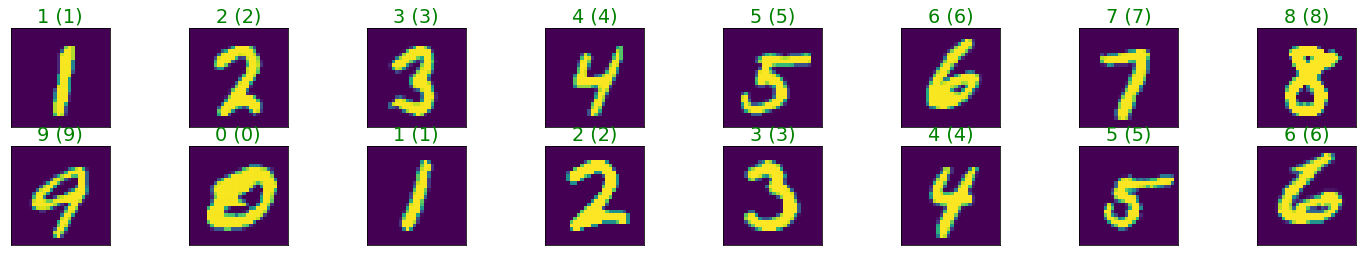

In [10]:

test_loss = 0.0

correct_class = list(i for i in range(10))
total_class = list(i for i in range(10))

model.eval()
for images, labels in test_loader:
    images, labels = images.cuda(), labels.cuda()
    output = model(images)
    loss = criterion(output, labels)
    test_loss += loss*images.shape[0]

    _,predict = torch.max(output, 1)
    correct_tensor = predict.eq(labels.data.view_as(predict))
    correct = np.squeeze(correct_tensor.numpy() if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy()))

    for i in range(labels.shape[0]):
        label = labels[i]
        correct_class[label] += correct[i].item()
        total_class[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print("test loss: {:.6f}".format(test_loss))
fig = plt.figure(figsize = (25, 4))
plt.rcParams.update({'font.size': 16})
for idx in np.arange(labels.shape[0]):
    ax = fig.add_subplot(2,labels.shape[0]/2, idx+1, xticks = [], yticks = [])
    plt.imshow(np.reshape(images.cpu()[idx]/2 + 0.5, (28,28)))
    ax.set_title("{} ({})".format(predict[idx] , labels[idx]), color= ('green' if predict[idx]==labels[idx].item() else "red"))

for i in range(10):
    if total_class[i] > 0:
        print("Test accuracy of {} : {}".format(i, 100*np.sum(correct_class[i])/np.sum(total_class[i])))
    else:
        print("{} is not tested..".format(i))

print("\nThe overal test accuracy is {}".format(100*np.sum(correct_class)/np.sum(total_class)))
bla = model(images[-1].view(1, 1, 28, 28))
donno,predict = torch.max(bla, 1)
print(bla, donno, predict.cpu().numpy()[0])

In [11]:
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
import imutils
import cv2
from google.colab.patches import cv2_imshow

In [12]:
def threshold(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 3)
    threshold_img = cv2.adaptiveThreshold(blurred, 225, 
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    threshold_img = cv2.bitwise_not(threshold_img)
    cv2_imshow(threshold_img)
    return threshold_img

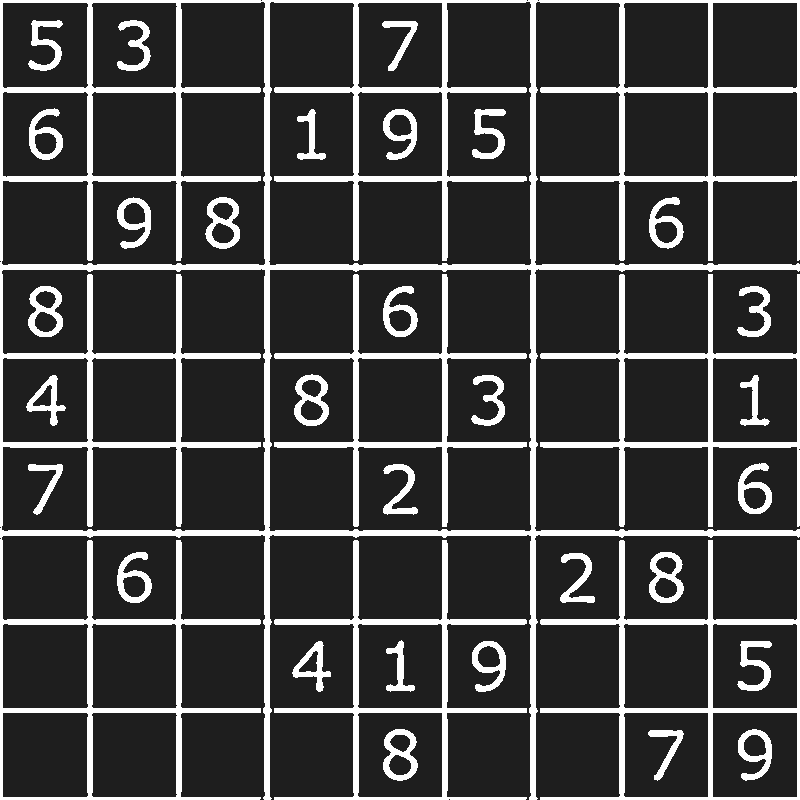

In [13]:
image = cv2.imread('images/sudoku.png')
thresh = threshold(image)

In [14]:
def find_contours(thresh, image):
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    puzzleCnt = None

    for c in cnts:
        line = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * line, True)

        if len(approx) == 4:
            puzzleCnt = approx
            break
    if puzzleCnt is None:
        raise Exception(("could not find sudoku puzzle outline."
            "try debugging your thresholding and contour steps."))
            
    output = image.copy()
    cv2.drawContours(output, [puzzleCnt], -1, (0,255,0), 2)
    cv2_imshow(output)
    puzzle = four_point_transform(image, puzzleCnt.reshape(4,2))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    warped = four_point_transform(gray, puzzleCnt.reshape(4,2))
    return (puzzle, warped)

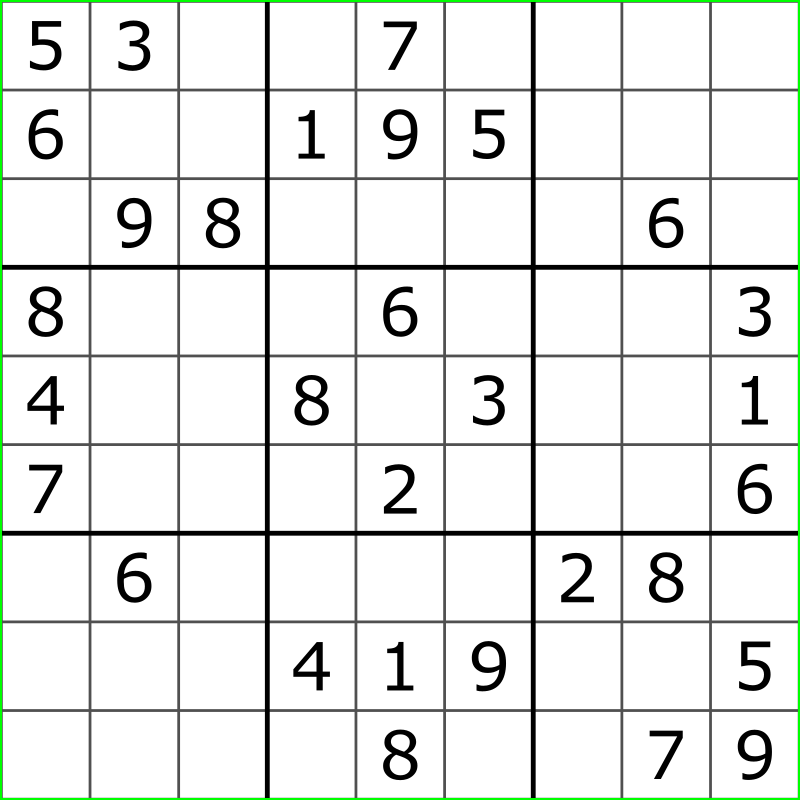

In [77]:
puzzle, warped =  find_contours(thresh, image)

In [16]:
def extract_digit(cell):
    thresh = cv2.threshold(cell, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    thresh = clear_border(thresh)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if len(cnts) == 0:
        return None

    c = max(cnts, key = cv2.contourArea)
    mask = np.zeros(thresh.shape, dtype=np.uint8) 
    cv2.drawContours(mask, [c], -1, 255, -1)
    (h, w) = thresh.shape
    percentFilled = cv2.countNonZero(mask) / float(w*h)
    if percentFilled < 0.03:
        return None
    digit = cv2.bitwise_and(thresh, thresh, mask=mask)
    return digit

In [17]:
%pip install py-sudoku
from sudoku import Sudoku

In [21]:
def solveit(image, thresh, model):
    image = imutils.resize(image, width = 600)
    (puzzleImage, warped) = find_contours(thresh, image)
    print(warped.shape)
    board = np.zeros((9,9), dtype="int")
    stepX =  67 #warped.shape[1] // 9
    stepY =  67 #warped.shape[0] // 9
    cellLocs = []
    for y in range(0, 9):
        row = []
        for x in range(0, 9):
            startX = x * stepX
            startY = y * stepY
            endX = (x + 1)*stepX
            endY = (y + 1)*stepY
            row.append((startX, startY, endX, endY))
            cell = warped[startY:endY, startX:endX]
            digit = extract_digit(cell)
            if digit is not None:
                roi = cv2.resize(digit, (28, 28))
                img = Image.fromarray(roi)
                img = transform(img)
                cell_value = img.cuda()
                cell_value = cell_value.float()
                cell_value = cell_value.unsqueeze(0)
                model.eval()
                out = model(cell_value.view(1, 1, 28, 28))
                _, predict = torch.max(out, 1)
                pred = predict.cpu().numpy()
                board[y, x] = pred[0]
        cellLocs.append(row)
    print("[INFO] OCR'd Sudoku board:")
    puzzle = Sudoku(3, 3, board=board.tolist())
    puzzle.show()
    print("[INFO] solving Sudoku puzzle...")
    solution = puzzle.solve()
    solution.show_full()
    return (cellLocs, solution)

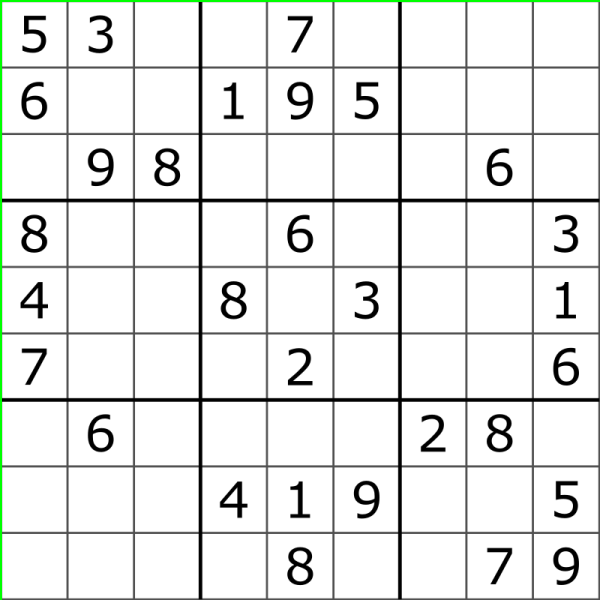

(799, 799)
[INFO] OCR'd Sudoku board:
+-------+-------+-------+
| 5 3   |   7   |       |
| 6     | 1 9 5 |       |
|   9 8 |       |   6   |
+-------+-------+-------+
| 8     |   6   |     3 |
| 4     | 8   3 |     1 |
| 7     |   2   |     6 |
+-------+-------+-------+
|   6   |       | 2 8   |
|       | 4 1 9 |     5 |
|       |   8   |   7 9 |
+-------+-------+-------+

[INFO] solving Sudoku puzzle...

---------------------------
9x9 (3x3) SUDOKU PUZZLE
Difficulty: SOLVED
---------------------------
+-------+-------+-------+
| 5 3 4 | 6 7 8 | 9 1 2 |
| 6 7 2 | 1 9 5 | 3 4 8 |
| 1 9 8 | 3 4 2 | 5 6 7 |
+-------+-------+-------+
| 8 5 9 | 7 6 1 | 4 2 3 |
| 4 2 6 | 8 5 3 | 7 9 1 |
| 7 1 3 | 9 2 4 | 8 5 6 |
+-------+-------+-------+
| 9 6 1 | 5 3 7 | 2 8 4 |
| 2 8 7 | 4 1 9 | 6 3 5 |
| 3 4 5 | 2 8 6 | 1 7 9 |
+-------+-------+-------+

        


In [22]:
(cellLocs, solution) = solveit(image, thresh, model)

In [82]:
def showsolution(cellLocs, solution):
    for (cellRow, boardRow) in zip(cellLocs, solution.board):
        for (box, digit) in zip(cellRow, boardRow):
            startX, startY, endX, endY = box
            startX = (warped.shape[0] // 9) * startX//67
            startY = (warped.shape[1] // 9) * startY//67 
            endX = 89 * endX//67 
            endY = 89 * endY//67 
            textX = int((endX - startX) * 0.33)
            textY = int((endY - startY) * -0.2)
            textX += startX
            textY += endY

            cv2.putText(puzzle, str(digit), (textX, textY), cv2.FONT_HERSHEY_SIMPLEX, 2, (155,180,155), 2)
    cv2_imshow(puzzle)
    cv2.imwrite("images/solved_puzzle.png",puzzle)

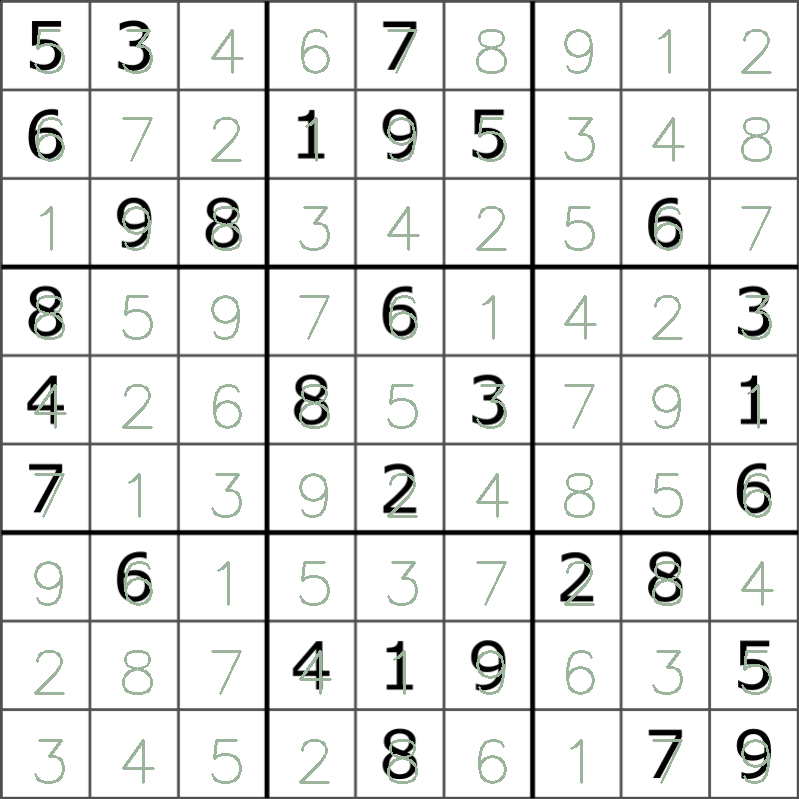

In [83]:
showsolution(cellLocs, solution)